In [46]:
import io
import sys

path = "drive/MyDrive/Datos_no_estructurados/WHATTSAPP/"

    
def replace_bad_character(line):
    return line.strip().replace(u"\u202a", "").replace(u"\u200e", "").replace(u"\u202c", "").replace(u"\xa0", " ")

try: 
    filepath = raw_input("Please input the chat filepath:")
except NameError:
    filepath = input("Please input chat filepath:")

try:
    with io.open(filepath, "r", encoding="utf-8") as file:
        content = [replace_bad_character(l) for l in file.readlines()]
    
except IOError as e:
    print("File \"" + filepath + "\" not found. Please recheck your file location")
    sys.exit()

common_words = []
cw_filepath = ""

cw_option = "Please select common word file or leave it blank to escape: \n\
    1: Indonesian (id_cw.py)\n\
    2: English (en_cw.py)\n\
    3: Spanish (es_cw.py)\n\
    4: German (de_cw.py)\n\
    5: Custom file\n\
    6: Skip common word\n"
try: 
    cw = raw_input(cw_option)
except NameError:
    cw = input(cw_option)
    
if cw == "1":
    cw_filepath = path+"id_cw"
elif cw == "2":
    cw_filepath = path+"en_cw"
elif cw == "3":
    cw_filepath = path+"es_cw"
elif cw == "4":
    cw_filepath = path+"de_cw"
elif cw == "5":
    """
    Prompt user to input the file path
    """
    try: 
        cw_filepath = raw_input("Please input your common word filepath")
    except NameError:
        cw_filepath = input("Please input your common word filepath")
else:
    print("You skipped common word.")

try:
    with open(f"{cw_filepath}.txt", "r") as fout:
      common_words = fout.read()

except:
    print("Error getting common word file location")
    sys.exit()

print(common_words)

try: 
    verbose = raw_input("You wanna print the verbose mode? y/[N]: ") == "y" or False
except NameError:
    verbose = input("You wanna print the verbose mode? y/[N]: ") == "y" or False
# ./drive/MyDrive/Datos_no_estructurados/WHATTSAPP/Chat_GirlsClub.txt

Please input chat filepath:./drive/MyDrive/Datos_no_estructurados/WHATTSAPP/Padel.txt
Please select common word file or leave it blank to escape: 
    1: Indonesian (id_cw.py)
    2: English (en_cw.py)
    3: Spanish (es_cw.py)
    4: German (de_cw.py)
    5: Custom file
    6: Skip common word
3
common_words = [
"de",
"la",
"las",
"estoy",
"que",
"el",
"multimedia",
"omitido",
"y",
"gif",
"imagen",
"omitida",
"sticker",
"n",
"a",
"los",
"del",
"se",
"por",
"un",
"con",
"para",
"no",
"una",
"su",
"al",
"lo",
"como",
"más",
"o",
"este",
"pero",
"sus",
"esta",
"si",
"ha",
"me",
"ya",
"le",
"son",
"sobre",
"entre",
"ser",
"fue",
"sin",
"todo",
"también",
"desde",
"cuando",
"muy",
"años",
"está",
"todos",
"hay",
"tiene",
"nos",
"porque",
"dos",
"hasta",
"donde",
"parte",
"así",
"han",
"puede",
"mi",
"año",
"cada",
"uno",
"vez",
"bien",
"hace",
"otros",
"eso",
"además",
"mismo",
"ese",
"hacer",
"yo",
"durante",
"te",
"día",
"tanto",
"esto",
"forma",
"estos",
"sólo",
"personas",
"ni",
"otro"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install emoji

     |████████████████████████████████| 133kB 13.8MB/s 


In [63]:
import re
import errno
import pandas as pd
import emoji
from collections import Counter
from dateutil import parser
import operator
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
"""
Global vars
"""
chat_of_members = {}
member_chat = {"member": [], "chat_count": []}
member_chat_words = {}
member_words = {}
words_list = []
attachments = {}
refered_web = {"domain": [], "d_count": []}
popular_words = {}
chat_words = ""
emojis = {"emj_char": [], "char_count": []}
heat_map = {
    "day": [], 
    "hour": [], 
    "chat_count": []
}
deleted_message = 0
pure_chat = ""
total_chat = 0

"""
Starting line mean a line that started with date time.
Because there are multiline chat. I called it following line.
A starting line must be classified before it's data being extracted.
"""
def is_starting_line(line):
    pattern = r"""
        (\[?)       #Zero or one open square bracket '['
        (((\d{1,2})   #1 to 2 digit date
        (/|-)       #'/' or '-' separator
        (\d{1,2})   #1 to 2 digit month
        (/|-)       #'/' or '-' separator
        (\d{2,4}))   #2 to 4 digit of year
        (,?\s)      #Zero or one comma ',' and ingle space
        ((\d{1,2})  #1 to 2 digit of hour
        (:|\.)      #Colon ':' or dot '.' separator
        (\d{2})     #2 digit of minute
        (\.|:)?     #Zero or one of dot '.' or colon ':'
        (\d{2})?    #Zero or one of 2 digits of second
        (\s[AP]M)?))  #Zero or one of ('space', 'A' or 'P', and 'M'
        (\]?\s-?\s?\s?)#Zero or one close square bracket ']', Zero or one (space and '-'), zero or one space
        (.+)        #One or more character of chat member phone number or contact name
    """
    
    return re.match(re.compile(pattern, re.VERBOSE), line)

"""
"Is Chat" means the body of a line is not an event.
May contains attachment
"""
def is_chat(body):
    pattern = r"""
            ([^:]+)#Chat member
            (:)   #Colon separator
            (.+)  #One or more charachter of message content
    """
    
    return re.match(re.compile(pattern, re.VERBOSE), body)

"""
Classify attachment
Note: in Android, there is no proper description wether it's a image, 
      video, audio, gif, or sticker.
"""
def contains_attachment(body):
    pattern_attachment = [
        ".*<Media omitted>$", #English version of android attachment
        ".*<Media tidak disertakan>$", #Indonesia version of android attachment
        ".*Pesan tidak didukung$", #Some device not recognize sticker attachment
        ".+\.vcf \(file\sterlampir\)$", #Indonesian version of android contact card,
        ".+\.vcf \(file\sattached\)$", #Indonesian version of android contact card,
        ".*image omitted$",
        ".*video omitted$",
        ".*document omitted$",
        ".*Contact card omitted$",
        ".*audio omitted$",
        ".*GIF omitted$",
        ".*sticker omitted$"
    ]
    
    for p in pattern_attachment:
        match = re.match(p, body)
        if match:
            return body
    return None

"""
Event means logs of chat activity e.g member left, member added, removed, etc.
This kind of line can not count as a chat
"""
def is_event(body):
    pattern_event = [
        "Messages to this group are now secured with end-to-end encryption\.$",
        ".+\screated this group$",
        ".+\skeluar$",
        ".+\sleft$",
        ".+\stelah bergabung menggunakan tautan undangan grup ini$",
        ".+\smenambahkan\s.+",
        ".+\sadded\s.+",
        ".+\sremoved\s.+",
        ".*You joined using this group's invite links$",
        ".+'s security code changed\.$",
        ".*telah mengganti nomor teleponnya ke nomor baru. Ketuk untuk mengirim pesan atau menambahkan nomor baru\.$",
        ".*changed their phone number to a new number. Tap to message or add the new number\.$"
    ]
    
    for p in pattern_event:
        match = re.match(p, body)
        if match:
            return match
    return None
"""
Deleted message
"""
def is_deleted(body):
    p = [
        ".*This message was deleted\.$",
        ".*Pesan ini telah dihapus$"
    ]
    
    for p in p:
        match = re.match(p, body)
        if match:
            return body
    return None

"""
EXTRACT TIMESTAMP
"""
def extract_timestamp(time_string):
    return parser.parse(time_string)

"""
Check if chat contais a url
"""
def extract_url(body):
    pattern = "https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+"
    
    return re.findall(pattern, body)

def get_domain(str):
    domain = str.replace("http://", '')
    domain = domain.replace("https://", '')
    domain = domain.split("/")
    return domain[0]

"""
EMOJI
"""
def extract_emojis(string):
    emj = re.findall(r'\d+(.*?)(?:\u263a|\U0001f645)', string)

    if len(emj) > 0:
        increment_emoji_count(emj)
    
    return emj

"""
Count top words
"""
def get_words(msg, user):
    
    #remove non alpha content
    regex = re.sub(r"[^a-z\s]+", "", msg.lower())
    regex = re.sub(r'[^\x00-\x7f]',r'', regex)
    words = regex.split(" ")
    
    for x in words:
        if x:
            rank_word(x, user)
            
    return words
        
def rank_word(word, user):
    
    if not word in common_words:
        popular_words[word] = popular_words.get(word, 0) + 1
        global chat_words
        chat_words += " {0}".format(word)
        
        increment_member_words(user, word)
        
    return word
    
"""
Counting function
"""

"""
Rank the 'Most Active user'
"""        
def increment_chat_count(member):
    member_chat["member"].append(member)
    member_chat["chat_count"].append(1)
    global total_chat
    total_chat += 1
    
    return member

def increment_member_words(member, word):
    
    if member != None:
        words_list = []
        if member not in member_words.keys():
            words_list.append(word)
            member_words[member] = words_list
        else:
            words_list = member_words[member]
            words_list.append(word)
            member_words[member] = words_list
        
    return member
 
def increment_attachment_count(message):
    
    if "image omitted" in message:
        attachments["image"] = attachments.get("image", 0) +1
        return
        
    if "video omitted" in message:
        attachments["video"] = attachments.get("video", 0) +1
        return
    
    if "audio omitted" in message:
        attachments["audio"] = attachments.get("audio", 0) +1
        return
    
    if "document omitted" in message:
        attachments["document"] = attachments.get("document", 0) +1
        return
    
    if "Contact card omitted" in message or ".vcf" in message:
        attachments["contact"] = attachments.get("contact", 0) +1
        return
    
    if "GIF omitted" in message:
        attachments["gif"] = attachments.get("gif", 0) +1
        return
    
    if "sticker omitted" in message:
        attachments["sticker"] = attachments.get("sticker", 0) +1
        return
    
    ##Unknown attachment
    attachments["unknown"] = attachments.get("unknown", 0) +1

    

def increment_link_count(urls):
    for url in urls:
        increment_domain_count(get_domain(url))
                    
    return len(urls)
    
def increment_domain_count(domain):
    refered_web["domain"].append(domain)
    refered_web["d_count"].append(1)

def increment_emoji_count(char_list):
    groups = Counter(char_list)
    for c in groups.items():
        emojis["emj_char"].append(c[0])
        emojis["char_count"].append(c[1])
        
def increment_heatmap(dt):
    heat_map["day"].append(dt.strftime("%A"))
    heat_map["hour"].append(dt.strftime("%H"))
    heat_map["chat_count"].append(1)

def increment_deleted():
    global deleted_message
    deleted_message += 1
"""
Self explained
"""
def parse_line(line, verbose):
    prefix = ""
    is_starting = is_starting_line(line)
    
    if is_starting:
        #Check wether the starting line is a chat or an event
        body = is_starting.group(18)
        chat = is_chat(body)
        dt = extract_timestamp(is_starting.group(2).replace(".", ":"))
        increment_heatmap(dt)
        
        if chat:
            has_attachment = contains_attachment(chat.group(3))
            increment_chat_count(chat.group(1)) #chat.group(1) es el member
            message_body = chat.group(3)
            user = chat.group(1)
            
            
            if has_attachment:
                prefix = "@@@" 
                increment_attachment_count(has_attachment)
                
                if verbose: print(bcolors.OKBLUE + bcolors.HEADER + prefix + line)
                
            else:
                if is_deleted(message_body):
                    increment_deleted()
                else:
                    prefix = "+++"
                    
                    #URL & Domain
                    urls = extract_url(message_body)
                    if urls:
                        increment_link_count(urls)

                    #Emoji
                    emjs = extract_emojis(message_body)
                    
                    #Word Count & Wordcloud
                    get_words(message_body, user)
                
                    if verbose: print(bcolors.OKGREEN + bcolors.HEADER + prefix + line)
                
        elif is_event(body):
            prefix = "***"
                
            if verbose: print(bcolors.WARNING + prefix + line)
        
    else:
        prefix = "|||"
        
        #URL & Domain
        urls = extract_url(line)
        if urls:
            increment_link_count(urls)
        
        #Emoji    
        emjs = extract_emojis(line)
        
        #Word Count & Wordcloud
        get_words(line, None)

        if verbose: print(bcolors.FAIL + prefix + line)

print("Extracting data. Please wait....")

for line in content:
    parse_line(line, verbose)
    
print("Done. You can run next cell.")

Se han truncado las últimas 5000 líneas del flujo de salida.
+++17/3/20 19:16 - Nano: Yo espero a Dave
+++17/3/20 19:17 - Nano: Cuanto te queda?
+++17/3/20 19:19 - Calleja: Estamos en privadas
+++17/3/20 19:19 - Calleja: Merete
+++17/3/20 19:20 - Ander: Yo echando me digáis estoy
+++17/3/20 19:24 - Ander: Cuando*
+++17/3/20 19:29 - Nano: Voy
+++17/3/20 19:29 - Nano: Me meto
+++17/3/20 19:58 - Deivid: Estoy de gym broders
+++17/3/20 19:58 - Deivid: Acabo en breves
+++17/3/20 19:58 - Deivid: No se si habra acabado de descargarse
+++17/3/20 20:39 - Ander: Acabamos de dejarlo
+++17/3/20 20:43 - Ander: Chavales miraos dos juegos que son de pc
+++17/3/20 20:43 - Ander: El dont starve together y el portal 2 a ver si os rentan
+++17/3/20 20:50 - Calleja: Hay que descargar?
+++17/3/20 21:10 - Nano: Eh
+++17/3/20 21:10 - Nano: Ojo un rocket league
+++17/3/20 21:10 - Nano: OJO
+++17/3/20 21:10 - Nano: descargo eso?
+++17/3/20 21:10 - Deivid: A mi me renta
+++17/3/20 21:12 - Calleja: Yo hoyo
+++17

In [59]:
a_list = '🤔 🙈 me así, bla es se 😌 ds 💕👭👙'
re.findall(r'[^\w\s,]', a_list)

['🤔', '🙈', '😌', '💕', '👭', '👙']

In [24]:
"""
DataFrame
"""
chat_per_member = (pd.DataFrame(member_chat)
                     .groupby(["member"])
                     .sum()
                     .sort_values(by = ['chat_count'], ascending=False))
popular_words_df = sorted(popular_words.items(), key=operator.itemgetter(1), reverse=True)
domains = (pd.DataFrame(refered_web)
                     .groupby(["domain"])
                     .sum()
                     .sort_values(by = ['d_count'], ascending=False))
emojis_df = (pd.DataFrame(emojis)
                     .groupby(["emj_char"])
                     .sum()
                     .sort_values(by = ['char_count'], ascending=False))
top_repeated_emoji = (pd.DataFrame(emojis)
                     .sort_values(by = ['char_count'], ascending=False))
heatmap_df = pd.DataFrame(heat_map)
grouped_heatmap = heatmap_df.groupby(["day", "hour"]).sum().sort_values(by=["chat_count"], ascending=False)
pivoted_heatmap = pd.pivot_table(grouped_heatmap, values='chat_count', index=['day'], columns=['hour'])

print("Done. You can run next cell.")

Done. You can run next cell.


In [25]:
for key in member_words.keys():
    words_list = member_words[key]
    a = " ".join(words_list)
    member_words[key] = a

member_words_df = pd.DataFrame([[key, member_words[key]] for key in member_words.keys()], columns=['User', 'Words'])
member_words_df.index = member_words_df.User
member_words_df

,User,Words
User,,
Girls club,Girls club,mensajes llamadas estn cifrados extremo extrem...
Sofia LM,Sofia LM,chicaas estaiis nica salimos tres jjaaja verge...
María S.,María S.,sofiii tal bieeen curro bueno ayuda pasen rpid...
Aroa LM,Aroa LM,sofa llev marca encontr izquierda suena finde ...
Isa LM,Isa LM,chicaaaaaaaaaas bon diaaaaaaq chachi grupo jej...


In [12]:
!pip install textblob
!pip install wordcloud

In [33]:
from textblob import TextBlob
    
pol = lambda x: TextBlob(x).sentiment.polarity
pol2 = lambda x: x.sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
sub2 = lambda x: x.sentiment.subjectivity
 
traducir = lambda x: TextBlob(x).translate(to="en")
 
member_words_df['blob_en'] = member_words_df['Words'].apply(traducir)
member_words_df['polarity'] = member_words_df['blob_en'].apply(pol2)
member_words_df['subjectivity'] = member_words_df['blob_en'].apply(sub2)
member_words_df = member_words_df.drop('Girls club ')
member_words_df.index

Index(['Sofia LM', 'María S.', 'Aroa LM', 'Isa LM'], dtype='object', name='User')

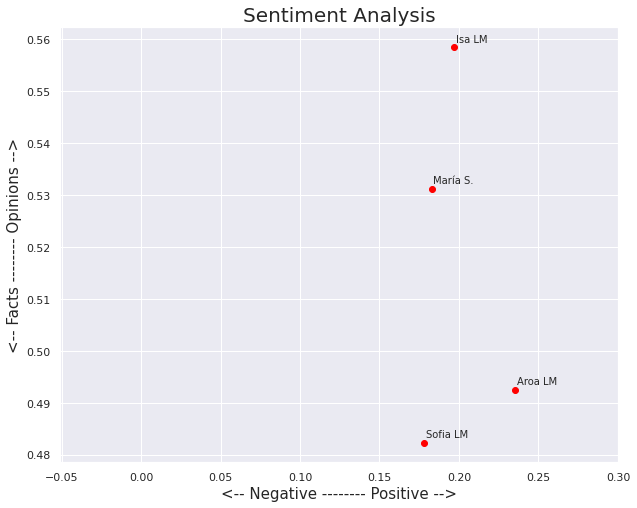

In [34]:
plt.rcParams['figure.figsize'] = [10, 8]
 
for index, user in enumerate(member_words_df.index):
    x = member_words_df.polarity.loc[user]
    y = member_words_df.subjectivity.loc[user]
    plt.scatter(x, y, color='red')
    plt.text(x+.001, y+.001, member_words_df['User'][user], fontsize=10)
    plt.xlim(-0.051, 0.3) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
 
plt.show()

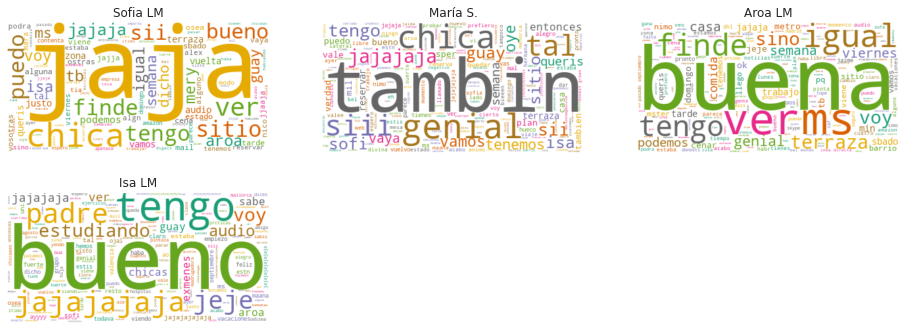

In [35]:
from wordcloud import WordCloud
 
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,12]
 
# Create subplots for each anio
for index, user in enumerate(member_words_df.index):
    wc.generate(member_words_df.Words[user])
    plt.subplot(4, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(user)
plt.show()

In [36]:
chat_per_member = chat_per_member.drop('Girls club ')

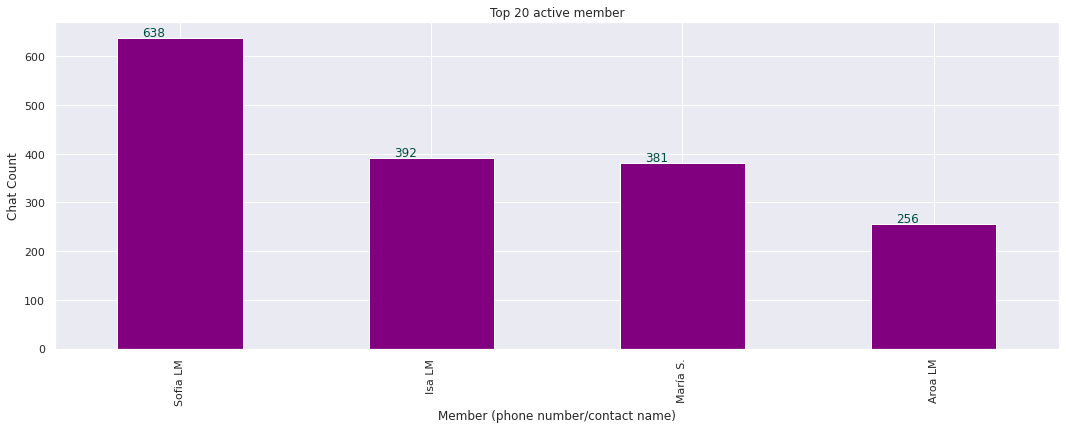

In [37]:
"""
Top Member Chat
"""
top_member = chat_per_member.head(20)
if not top_member.empty:
    sns.set()
    member_plot = top_member.plot(kind='bar', legend=None, title="Top 20 active member", figsize=(18, 6), color="purple")
    member_plot.set_xlabel("Member (phone number/contact name)")
    member_plot.set_ylabel("Chat Count")
    for i, v in enumerate(top_member["chat_count"]):
        member_plot.text(i - .15, v + 3, v, color="#004d40")
else:
    print("This chat has no member")

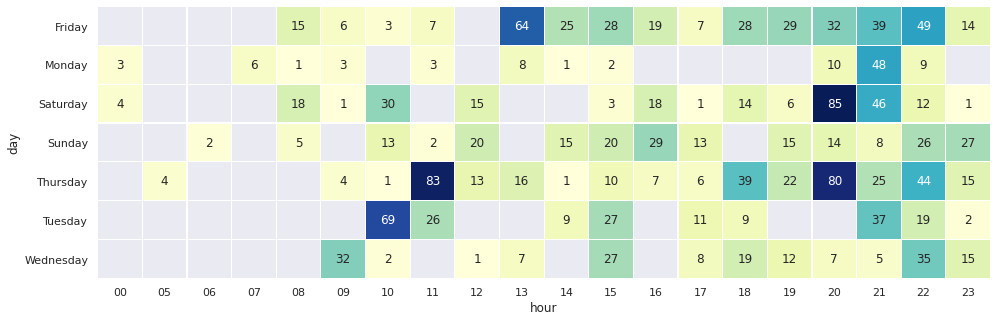

In [38]:
"""
Heatmap
"""
heatmap_df = pd.DataFrame(heat_map)
if not heatmap_df.empty:
    grouped_heatmap = heatmap_df.groupby(["day", "hour"]).sum().sort_values(by=["chat_count"], ascending=False)
    pivoted_heatmap = pd.pivot_table(grouped_heatmap, values='chat_count', index=['day'], columns=['hour'])
    plt.figure(figsize = (16,5))
    sns.heatmap(pivoted_heatmap, 
                annot=True, 
                fmt=".0f", 
                linewidths=.2,
                cmap="YlGnBu",
                cbar=False
               )
else:
    print("This chat does not contain any datetime")

In [39]:
s_attachments = sorted(attachments.items(), key = operator.itemgetter(1), reverse=True)
if s_attachments:
    at_labels = [x[0].title() + " " + str(x[1]) for x in s_attachments]

    at_explode = tuple([0 + i * 0.1 for i in range(len(s_attachments))])
    at_sizes = [x[1] for x in s_attachments]
    at_colors = ["#FF6D00", "#64DD17", "#00B8D4", "#304FFE", "#AA00FF", "#d50000", "#546E7A", "#dddddd"]
    at_pie = plt.pie(at_sizes,  
             autopct='%1.1f%%',
             explode=at_explode,
             pctdistance=1.2,
             colors=at_colors,
             startangle=160,
             radius=1.3,
             wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },
    )

    at_centre_circle = plt.Circle((0,0),0.85,color='white', fc='white',linewidth=1.25)
    at_fig = plt.gcf()
    at_fig.gca().add_artist(at_centre_circle)

    plt.legend(
        loc='upper left',
        labels=at_labels,
        prop={'size': 11},
        bbox_to_anchor=(1, 1)
    )
    at_axis = plt.axis('equal')
else:
    print("This chat contains no attachment.")

This chat contains no attachment.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


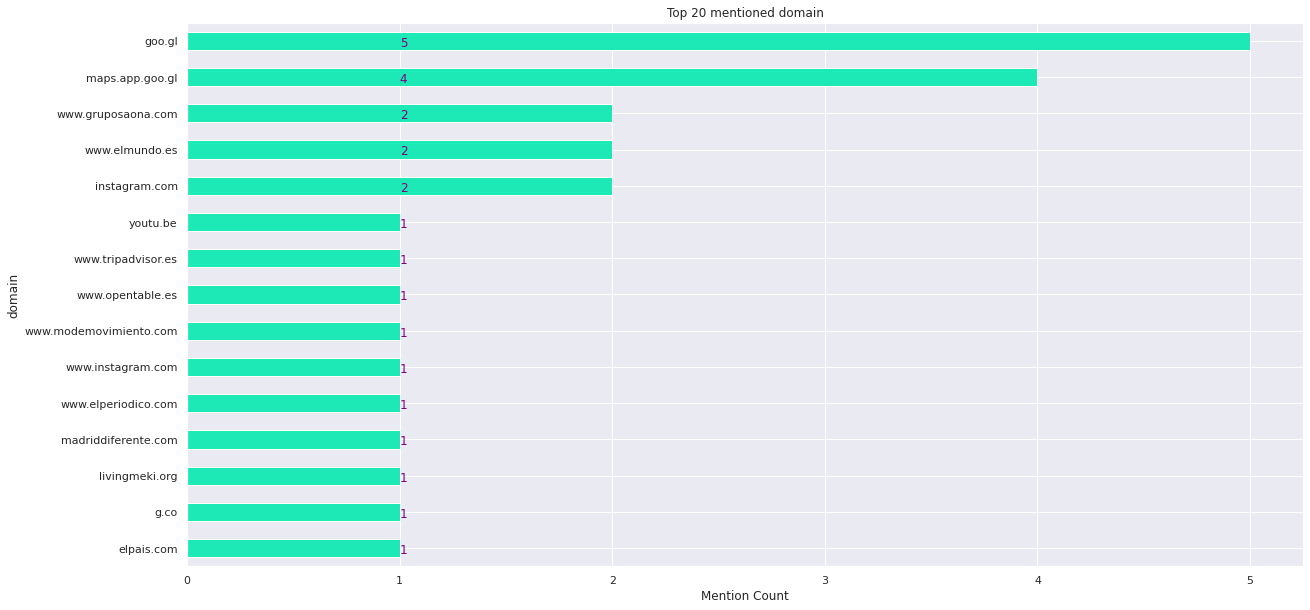

In [40]:
"""
Top Website
"""
top_web = domains.head(20).sort_values("d_count")
if not top_web.empty:
    mpl.rc('font', **{'sans-serif' : 'arial', 'family' : 'sans-serif'})
    web_plot = top_web.plot(kind='barh', legend=None, title="Top 20 mentioned domain", figsize=(20,10), color="#1de9b6")
    web_plot.set_xlabel("Mention Count")
    for i, v in enumerate(top_web["d_count"]):
        web_plot.text(1, i - .15, v, color="purple")
else:
    print("This chat not contains any link")

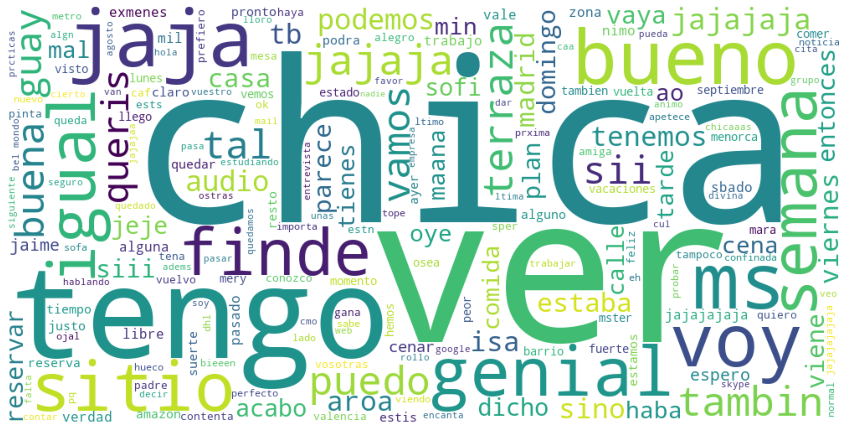

In [41]:
"""
Wordcloud
"""
if chat_words:
    wordcloud = WordCloud(
        width = 1000, 
        height = 500,
        background_color = "white"
    ).generate(chat_words)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
else:
    print("This chat contains no word")

In [42]:
"""
Raw Output
"""
print("\n=======================================\n")
print("#Total Chat: {0}".format(total_chat))
print("#Deleted Message: {0}".format(deleted_message))
print("#Total Attachment: {0}".format(sum([x[1] for x in s_attachments])))
for a in s_attachments:
    print("  - : {0}".format(a))
    


print("\n#Top 20 Member")
print("-----------------")
print(top_member)


print("\n#Top 20 Words")
print("-----------------")
for k, v in enumerate(popular_words_df):
    if k < 20:
        print(v)
    else:
        break
        
print("\n#Top 20 Emoji")
print("-----------------")
print(emojis_df.head(20))

print("\n#Top 20 Mentioned Website")
print("-----------------")
print(top_web.sort_values("d_count", ascending=False))



#Total Chat: 1668
#Deleted Message: 0
#Total Attachment: 0

#Top 20 Member
-----------------
          chat_count
member              
Sofia LM         638
Isa LM           392
María S.         381
Aroa LM          256

#Top 20 Words
-----------------
('chicas', 43)
('ver', 38)
('tengo', 37)
('jaja', 30)
('ms', 30)
('bueno', 28)
('voy', 27)
('genial', 26)
('igual', 24)
('jajaja', 23)
('tambin', 22)
('puedo', 21)
('finde', 21)
('tal', 20)
('semana', 20)
('vamos', 20)
('sitio', 20)
('sii', 19)
('guay', 18)
('queris', 18)

#Top 20 Emoji
-----------------
Empty DataFrame
Columns: [char_count]
Index: []

#Top 20 Mentioned Website
-----------------
                        d_count
domain                         
goo.gl                        5
maps.app.goo.gl               4
instagram.com                 2
www.elmundo.es                2
www.gruposaona.com            2
elpais.com                    1
g.co                          1
livingmeki.org                1
madriddiferente.com        

**Análisis de sentimientos**

In [43]:
emojis_df

,char_count
emj_char,
